## Predicting news relevancy

In [1]:
# Basic ML things
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import os
from pprint import pprint

#### Loading the data

In [2]:
# Checking our data files.

DATA = './data'
print(os.listdir(DATA))

['test.csv', 'training-1.csv']


In [3]:
# Splitting data into train and validation sets.

all_df = pd.read_csv(os.path.join(DATA, 'training-1.csv'), index_col='id')

train_df, test_df = train_test_split(all_df, test_size=0.2)

print('Shape of train dataset = {}'.format(train_df.shape))
print('Shape of test dataset = {}'.format(test_df.shape))

train_df.head()

Shape of train dataset = (7534, 29)
Shape of test dataset = (1884, 29)


,age,app_type,owner_type,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,...,participant2_action,participant2_gender,participant2_focus,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_focus,participant3_influence,rank
id,,,,,,,,,,,,,,,,,,,,,
267446,5.370325e+09,other,space,0.99973,4,0,0,0,1,146,...,liked,female,other,0.99754,17,liked,female,marketing,0.99896,0.83028
247307,1.885073e+10,wiki,space,0.50000,1,0,0,0,1,124733,...,viewed,male,other,0.23077,3080,viewed,male,marketing,0.23077,0.68673
175464,6.290477e+10,other,space,0.99923,7,1,1,0,1,13,...,liked,male,other,0.99630,7,liked,male,marketing,0.99886,0.85489
263732,7.723549e+09,other,space,0.99949,1,1,0,0,1,119774,...,liked,male,marketing,0.99962,22636,viewed,male,other,0.23077,0.79118
221667,3.146947e+10,forum,space,0.99977,1,2,0,0,1,124732,...,commented,male,marketing,0.99402,126985,liked,male,other,0.99466,0.82705


In [4]:
test_df.to_csv(os.path.join(DATA, 'test.csv'))

### Exploratory Data Analysis

#### Checking missing values

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7534 entries, 267446 to 260054
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          7534 non-null   float64
 1   app_type                     7534 non-null   object 
 2   owner_type                   7534 non-null   object 
 3   owner_influence              7534 non-null   float64
 4   number_of_likes              7534 non-null   int64  
 5   number_of_comments           7534 non-null   int64  
 6   is_commented_by_connections  7534 non-null   int64  
 7   is_liked_by_me               7534 non-null   int64  
 8   is_liked_by_connections      7534 non-null   int64  
 9   poster_id                    7534 non-null   int64  
 10  poster_gender                7534 non-null   object 
 11  poster_focus                 7534 non-null   object 
 12  poster_influence             7534 non-null   float64
 13  participant

Luckily, we don't have any missing values. So there is no need to handle 'null's.

#### Exploring 'label' column

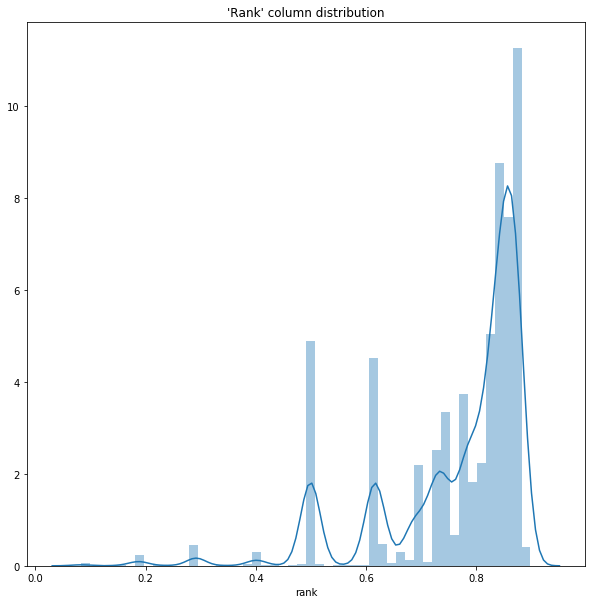

In [6]:
plt.figure(figsize=(10, 10))
plt.title("'Rank' column distribution")

sns.distplot(train_df['rank'])

Data does not follow normal distribution. Also we have some anomalous behaviour at around 0.5 and 0.6 values.

#### Reviewing outliers

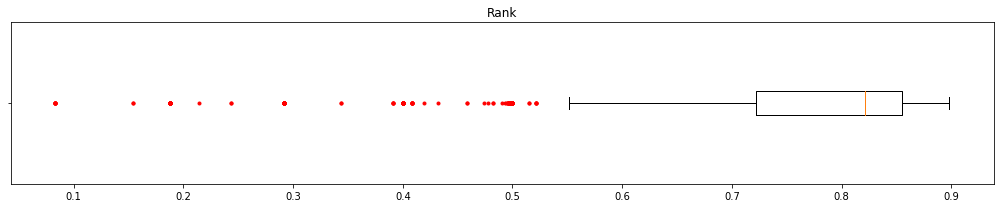

In [7]:
plt.figure(figsize=(14, 3))
plt.boxplot(x=train_df['rank'], vert=False, sym="r.")
plt.tick_params(labelleft=False)
plt.title('Rank')

plt.tight_layout()

We can see that we have many outliers, but none of them are typing or human errors (as all of them are in logical range between 0 and 1), so we do not need to process them. Those are the values that are just hard to get, but not impossible.

### Checking summary statistics

In [8]:
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Number columns: {}".format(num_cols), end="\n\n")
print("Categorical columns: {}".format(cat_cols))

Number columns: ['age', 'owner_influence', 'number_of_likes', 'number_of_comments', 'is_commented_by_connections', 'is_liked_by_me', 'is_liked_by_connections', 'poster_id', 'poster_influence', 'participant1_id', 'participant1_influence', 'participant2_id', 'participant2_influence', 'participant3_id', 'participant3_influence']

Categorical columns: ['app_type', 'owner_type', 'poster_gender', 'poster_focus', 'participant1_action', 'participant1_gender', 'participant1_focus', 'participant2_action', 'participant2_gender', 'participant2_focus', 'participant3_action', 'participant3_gender', 'participant3_focus']


#### Numerical columns

In [9]:
train_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,7534.0,3.407886e+10,1.757247e+10,4.147070e+09,2.109536e+10,3.251597e+10,4.728118e+10,2.050660e+11
owner_influence,7534.0,7.764587e-01,3.674968e-01,1.000000e-01,7.435900e-01,9.992300e-01,9.997700e-01,9.999200e-01
number_of_likes,7534.0,4.372578e+00,6.881767e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,6.300000e+01
number_of_comments,7534.0,1.649854e+00,3.913072e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.450000e+02
is_commented_by_connections,7534.0,4.936289e-01,4.999926e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_liked_by_me,7534.0,3.198832e-02,1.759806e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_liked_by_connections,7534.0,6.554287e-01,4.752598e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
poster_id,7534.0,4.966205e+04,5.738412e+04,1.000000e+00,1.700000e+01,1.420000e+02,1.170860e+05,1.291040e+05
poster_influence,7534.0,9.657117e-01,1.506297e-01,9.091000e-02,9.958600e-01,9.980600e-01,9.989500e-01,9.996200e-01
participant1_id,7534.0,3.855073e+04,5.031230e+04,1.000000e+00,1.700000e+01,1.365900e+04,1.080250e+05,1.291040e+05


Columns {poster_id, participant1_id, participant2_id, participant3_id} are just identificators for users, it is unlikely that we get some useful insights from here without info about this users.

Columns {is_commented_by_connections, is_liked_by_me, is_liked_by_connections} are 'dummy' onehot variables, which can have only 2 values: 0 and 1.

#### Categorical columns

In [10]:
train_df[cat_cols].nunique()

app_type               6
owner_type             2
poster_gender          2
poster_focus           5
participant1_action    3
participant1_gender    2
participant1_focus     4
participant2_action    3
participant2_gender    2
participant2_focus     4
participant3_action    3
participant3_gender    2
participant3_focus     4
dtype: int64

All of the columns have no more than 6 unique values.

Also, let's take a closer look on this data to know better what we are dealing with.

In [11]:
print("Unique values in every categorical column:", end="\n\n")
for col in cat_cols:
    print("{:19s} --> {}".format(col, train_df[col].unique()))

Unique values in every categorical column:

app_type            --> ['other' 'wiki' 'forum' 'calendar' 'poll' 'social']
owner_type          --> ['space' 'user']
poster_gender       --> ['male' 'female']
poster_focus        --> ['marketing' 'other' 'sales' 'engineering' 'none']
participant1_action --> ['liked' 'commented' 'viewed']
participant1_gender --> ['female' 'male']
participant1_focus  --> ['marketing' 'other' 'sales' 'engineering']
participant2_action --> ['liked' 'viewed' 'commented']
participant2_gender --> ['female' 'male']
participant2_focus  --> ['other' 'marketing' 'engineering' 'sales']
participant3_action --> ['liked' 'viewed' 'commented']
participant3_gender --> ['female' 'male']
participant3_focus  --> ['marketing' 'other' 'sales' 'engineering']


Columns {poster_focus, participant1_focus, participant2_focus, participant3_focus} contain 'none' value. According to description of the data, we can change it to 'other' value.

## Preprocessing data

#### Dropping redundant columns

In [12]:
drop_cols = ['poster_id', 'participant1_id', 'participant2_id', 'participant3_id']
num_cols = [i for i in num_cols if i not in drop_cols]
train_df = train_df.drop(drop_cols, axis=1)
train_df.head()

,age,app_type,owner_type,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_gender,...,participant1_influence,participant2_action,participant2_gender,participant2_focus,participant2_influence,participant3_action,participant3_gender,participant3_focus,participant3_influence,rank
id,,,,,,,,,,,,,,,,,,,,,
267446,5.370325e+09,other,space,0.99973,4,0,0,0,1,male,...,0.99540,liked,female,other,0.99754,liked,female,marketing,0.99896,0.83028
247307,1.885073e+10,wiki,space,0.50000,1,0,0,0,1,female,...,0.99610,viewed,male,other,0.23077,viewed,male,marketing,0.23077,0.68673
175464,6.290477e+10,other,space,0.99923,7,1,1,0,1,male,...,0.99919,liked,male,other,0.99630,liked,male,marketing,0.99886,0.85489
263732,7.723549e+09,other,space,0.99949,1,1,0,0,1,male,...,0.99453,liked,male,marketing,0.99962,viewed,male,other,0.23077,0.79118
221667,3.146947e+10,forum,space,0.99977,1,2,0,0,1,male,...,0.99756,commented,male,marketing,0.99402,liked,male,other,0.99466,0.82705


#### Modifying 'poster_focus' column

In [13]:
train_df['poster_focus'] = train_df['poster_focus'].apply(lambda row: 'other' if row == 'none' else row)
print("'poster_focus' --> {}".format(train_df['poster_focus'].unique()))

'poster_focus' --> ['marketing' 'other' 'sales' 'engineering']


#### Normalizing data

Column 'age' has very large values, we need to rescale it for better training.

In [17]:
train_df['age'] = (train_df['age'] - train_df['age'].mean()) / train_df['age'].std()
train_df['age'].describe()

count    7.534000e+03
mean    -6.224558e-17
std      1.000000e+00
min     -1.703334e+00
25%     -7.388548e-01
50%     -8.894004e-02
75%      7.513066e-01
max      9.730396e+00
Name: age, dtype: float64

### Tensorflow Magic

In [18]:
feature_columns = []

# numerical columns
for col in num_cols:
    feature_columns.append(tf.feature_column.numeric_column(col))

# categorical columns
for col in cat_cols:
    feature_columns.append(tf.feature_column.indicator_column(
                           tf.feature_column.categorical_column_with_vocabulary_list(col, train_df[col].unique())))

pprint(feature_columns)

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='owner_influence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='number_of_likes', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='number_of_comments', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='is_commented_by_connections', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='is_liked_by_me', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='is_liked_by_connections', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='poster_influence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='participant1_influence', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 

#### Feature Crosses

In [19]:
# Feature crosses
participant1_overview = tf.feature_column.indicator_column(tf.feature_column.crossed_column(
                        ['participant1_action', 'participant1_focus', 'participant1_gender'], 50000))
participant2_overview = tf.feature_column.indicator_column(tf.feature_column.crossed_column(
                        ['participant2_action', 'participant2_focus', 'participant2_gender'], 50000))
participant3_overview = tf.feature_column.indicator_column(tf.feature_column.crossed_column(
                        ['participant3_action', 'participant3_focus', 'participant3_gender'], 50000))

feature_columns += [participant1_overview, participant2_overview, participant3_overview]

## Building model

In [20]:
fp_feature_layer = DenseFeatures(feature_columns)  # input layer created from features

model = Sequential([fp_feature_layer,
                    Dense(50, activation='relu'), 
                    Dense(1, activation='sigmoid')])

In [21]:
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [22]:
features = {name: np.array(value) for name, value in train_df.items()}  # creating feed-dictionary
label = np.array(features.pop('rank'))  # target column

model.fit(features, label, epochs=10, batch_size=10)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train on 7534 samples
Epoch 1/10
7534/7534 [==============================] - 42s 6ms/sample - loss: 0.0062 - mse: 0.0062
Epoch 2/10
7534/7534 [==============================] - 42s 6ms/sample - loss: 0.0027 - mse: 0.0027
Epoch 3/10
7534/7534 [==============================] - 38s 5ms/sample - loss: 0.0022 - mse: 0.0022
Epoch 4/10
7534/7534 [==============================] - 36s 5ms/sample - loss: 0.0019 - mse: 0.0019
Epoch 5/10
7534/7534 [==============================] - 40s 5ms/sample - loss: 0.0017 - mse: 0.0017
Epoch 6/10
7534/7534 [==============================] - 37s 5ms/sample - loss: 0.0016 - mse: 0.0016
Epoch 

In [23]:
# Saving the model

model.save('model.h5')

### Predicting new values

In [24]:
def predict(filename):
    """
    Function for preprocessing new data and predicting 'rank' values, using trained model.
    """
    
    df = pd.read_csv(os.path.join(DATA, filename))
    
    # Changing some of the focus columns
    df['poster_focus'] = df['poster_focus'].apply(lambda row: 'other' if row == 'none' else row)

    # Dropping redundant columns
    df = df.drop(drop_cols, axis=1)

    # Rescaling 'age' column
    df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()
    
    # Using the model
    f = {name: np.array(value) for name, value in df.items() if name != 'rank'}
    y = model.predict(f)
    return y

In [25]:
y_pred = predict('test.csv')

In [26]:
# Checking with real answers

y = pd.read_csv(os.path.join(DATA, 'test.csv'))['rank'].to_numpy().reshape(-1, 1)

In [27]:
# Calculating MSE for test data

mse = np.sum((y - y_pred) ** 2) / len(y)
print(mse)

0.001339342431878736
